# Qualitative Results Auto View

Running by this ipynb you will get the full qualitative results of the paper.

The camera position is already in the dataset, check the dataset folder for more information.

Remember to install the package you need:

`conda install -c conda-forge pyvista ipywidgets Pillow`

Some package issues I met before:
- https://github.com/slundberg/shap/issues/1043
- memory leak problem: https://github.com/pyvista/pyvista/issues/482

In [1]:
# Created: 2023-05-11 22:35
# @Copyright (C) 2023-now, RPL, KTH Royal Institute of Technology
# @Author: Kin ZHANG  (https://kin-zhang.github.io/)

# If you find this repo helpful, please cite the respective publication in DUFOMap.
# This script is licensed under the terms of the MIT license.
# For a copy, see <https://opensource.org/licenses/MIT>.

import numpy as np
import pyvista as pv
pv.set_jupyter_backend('trame')
def view_pcd2img(pcd_np_data, camera_view_file, save_img_path, show_pred_dynamic=False, show_false_diff=False):
    label_colors = {0: [145, 191, 219], # blue static TN
                    1: [239, 133, 84],   # orange FN
                    2: [255, 255, 191], # yellow TP
                    3: [239, 133, 84]   # red [240, 59, 32] FP, orange [239, 133, 84]
                    }
    plotter = pv.Plotter(off_screen=True, notebook=True)
    plotter.enable_eye_dome_lighting()
    plotter.enable_trackball_style()
    plotter.set_background([236, 235, 235])
    # if show_dynamic:
    cloud = pv.PolyData(pcd_np_data[:,:3])
    labels = pcd_np_data[:,3]
    show_label = [0,1,2,3]
    
    if show_pred_dynamic and not show_false_diff:
        labels[labels==3] = 0
        labels[labels==1] = 2
        show_label = [0,2]
    elif show_pred_dynamic and show_false_diff: # show output static
        labels[labels==3] = 0
        show_label = [0,1,2]
    elif not show_pred_dynamic and show_false_diff:
        show_label = [0,3]
    elif not show_pred_dynamic and not show_false_diff: # show output static with single color (blue)
        labels[labels==3] = 0
        show_label = [0]

    cloud["labels"] = labels.flatten()

    for label, color in label_colors.items():
        if label not in show_label:
            continue
        draw_pt = cloud.extract_points(cloud["labels"] == label)
        if draw_pt.n_points>0:
            plotter.add_mesh(draw_pt, point_size=5, color=color)
    
    loaded_camera_position = []
    with open(camera_view_file, "r") as file:
        lines = file.readlines()
        for line in lines:
            loaded_camera_position.append(eval(line.strip()))
            
    loaded_camera_position = tuple(loaded_camera_position)
    plotter.camera_position = loaded_camera_position
    plotter.show(screenshot=save_img_path)
    plotter.close()
    plotter.clear()
    plotter.close()

Produce all methods clean and dynamic map, false point will mark as orange

In [ ]:
import sys, os
BASE_DIR = os.path.abspath(os.path.join(os.path.dirname( os.path.abspath('') )))
sys.path.insert(0, BASE_DIR)

from utils.pcdpy3 import load_pcd
from utils import check_file_exists
Result_Folder = "/home/kin/workspace/DUFOMap/data" 
algorithms = ["dynablox", "dufomap", "erasor", "octomap"]
for save_type in ["clean","dynamic"]: #  "clean", # sometime out of memory
    show_dynamic = True if save_type == "dynamic" else False
    for data_name in ["av2"]: # "05", , "av2"
        camera_view = f"{Result_Folder}/{data_name}/imgs/camera_position.txt"
        gt_pcd_path = f"{Result_Folder}/{data_name}/gt_cloud.pcd"
        check_file_exists(gt_pcd_path)
        gt_pc_ = load_pcd(gt_pcd_path)
        img_path = f"{Result_Folder}/{data_name}/imgs/gt_{save_type}.png"
        if not os.path.exists(img_path):
            gt_pc_.np_data[gt_pc_.np_data[:,3] == 1, 3] = 2
            view_pcd2img(gt_pc_.np_data, camera_view, img_path, show_pred_dynamic=show_dynamic, show_false_diff=True)
            print(f"Saved {img_path}")
        for algo in algorithms:
            et_pcd_path = f"{Result_Folder}/{data_name}/eval/{algo}_output_exportGT.pcd"
            check_file_exists(et_pcd_path)
            et_pc_ = load_pcd(et_pcd_path)
            img_path = f"{Result_Folder}/{data_name}/imgs/{algo}_{save_type}.png"
            TN_mask = (et_pc_.np_data[:,3] == 0) * (gt_pc_.np_data[:,3] == 0)
            FN_mask = (et_pc_.np_data[:,3] == 1) * (gt_pc_.np_data[:,3] == 0)
            TP_mask = (et_pc_.np_data[:,3] == 1) * (gt_pc_.np_data[:,3] == 1)
            FP_mask = (et_pc_.np_data[:,3] == 0) * (gt_pc_.np_data[:,3] == 1)
            et_pc_.np_data[TN_mask, 3]=0 # TN
            et_pc_.np_data[FN_mask, 3]=1 # FN
            et_pc_.np_data[TP_mask, 3]=2 # TP
            et_pc_.np_data[FP_mask, 3]=3 # FP
            view_pcd2img(et_pc_.np_data, camera_view, img_path, show_pred_dynamic=show_dynamic, show_false_diff=True)
            print(f"Saved {img_path}")

Debug mode: so we can change camera position or the specific scene we want to see

In [4]:
# clean fig in Fig.6 third row of the DUFOMap paper
import sys, os
BASE_DIR = os.path.abspath(os.path.join(os.path.dirname( os.path.abspath('') )))
sys.path.insert(0, BASE_DIR)

from utils.pcdpy3 import load_pcd
from utils import check_file_exists
Result_Folder = "/home/kin/workspace/DUFOMap/data" 
algorithms = ["dynablox", "dufomap", "octomap", "erasor"]
save_type = "clean"

data_name = "av2"
camera_view = f"{Result_Folder}/{data_name}/imgs/camera_position_v2.txt"
gt_pcd_path = f"{Result_Folder}/{data_name}/gt_cloud.pcd"
check_file_exists(gt_pcd_path)
gt_pc_ = load_pcd(gt_pcd_path)
img_path = f"{Result_Folder}/{data_name}/imgs/gt_{save_type}.png"
for algo in algorithms:
    et_pcd_path = f"{Result_Folder}/{data_name}/eval/{algo}_output_exportGT.pcd"
    check_file_exists(et_pcd_path)
    et_pc_ = load_pcd(et_pcd_path)
    TN_mask = (et_pc_.np_data[:,3] == 0) * (gt_pc_.np_data[:,3] == 0)
    FN_mask = (et_pc_.np_data[:,3] == 1) * (gt_pc_.np_data[:,3] == 0)
    TP_mask = (et_pc_.np_data[:,3] == 1) * (gt_pc_.np_data[:,3] == 1)
    FP_mask = (et_pc_.np_data[:,3] == 0) * (gt_pc_.np_data[:,3] == 1)
    et_pc_.np_data[TN_mask, 3]=0 # TN
    et_pc_.np_data[FN_mask, 3]=1 # FN
    et_pc_.np_data[TP_mask, 3]=2 # TP
    et_pc_.np_data[FP_mask, 3]=3 # FP
    
    img_path = f"{Result_Folder}/{data_name}/imgs/{algo}_{save_type}.png"
    view_pcd2img(et_pc_.np_data, camera_view, img_path, show_pred_dynamic=False, show_false_diff=True)
    print(f"Saved {img_path}")
if not os.path.exists(img_path):
    gt_pc_.np_data[gt_pc_.np_data[:,3] == 1, 3] = 2
    view_pcd2img(gt_pc_.np_data, camera_view, img_path, show_pred_dynamic=False, show_false_diff=True)
    print(f"Saved {img_path} on ground truth")

Widget(value="<iframe src='http://localhost:34359/index.html?ui=P_0x7f0fc04f8c40_0&reconnect=auto' style='widt…

Saved /home/kin/workspace/DUFOMap/data/av2/imgs/dufomap_clean.png


Widget(value="<iframe src='http://localhost:34359/index.html?ui=P_0x7f0f8246eaf0_0&reconnect=auto' style='widt…

Saved /home/kin/workspace/DUFOMap/data/av2/imgs/octomap_clean.png


Widget(value="<iframe src='http://localhost:34359/index.html?ui=P_0x7f0f81a86eb0_0&reconnect=auto' style='widt…

Saved /home/kin/workspace/DUFOMap/data/av2/imgs/erasor_clean.png


In [ ]:
# clean fig in Fig.6 third row of the DUFOMap paper
import sys, os
BASE_DIR = os.path.abspath(os.path.join(os.path.dirname( os.path.abspath('') )))
sys.path.insert(0, BASE_DIR)

from utils.pcdpy3 import load_pcd
from utils import check_file_exists
Result_Folder = "/home/kin/workspace/DUFOMap/data" 
algorithms = ["dynablox", "dufomap", "octomap", "erasor"]
save_type = "dynamic"

data_name = "av2"
camera_view = f"{Result_Folder}/{data_name}/imgs/camera_position.txt"
gt_pcd_path = f"{Result_Folder}/{data_name}/gt_cloud.pcd"
check_file_exists(gt_pcd_path)
gt_pc_ = load_pcd(gt_pcd_path)
img_path = f"{Result_Folder}/{data_name}/imgs/gt_{save_type}.png"
if not os.path.exists(img_path):
    gt_pc_.np_data[gt_pc_.np_data[:,3] == 1, 3] = 2
    view_pcd2img(gt_pc_.np_data, camera_view, img_path, show_pred_dynamic=True, show_false_diff=True)
    print(f"Saved {img_path} on ground truth")
for algo in algorithms:
    et_pcd_path = f"{Result_Folder}/{data_name}/eval/{algo}_output_exportGT.pcd"
    check_file_exists(et_pcd_path)
    et_pc_ = load_pcd(et_pcd_path)
    TN_mask = (et_pc_.np_data[:,3] == 0) * (gt_pc_.np_data[:,3] == 0)
    FN_mask = (et_pc_.np_data[:,3] == 1) * (gt_pc_.np_data[:,3] == 0)
    TP_mask = (et_pc_.np_data[:,3] == 1) * (gt_pc_.np_data[:,3] == 1)
    FP_mask = (et_pc_.np_data[:,3] == 0) * (gt_pc_.np_data[:,3] == 1)
    et_pc_.np_data[TN_mask, 3]=0 # TN
    et_pc_.np_data[FN_mask, 3]=1 # FN
    et_pc_.np_data[TP_mask, 3]=2 # TP
    et_pc_.np_data[FP_mask, 3]=3 # FP
    
    img_path = f"{Result_Folder}/{data_name}/imgs/{algo}_{save_type}.png"
    view_pcd2img(et_pc_.np_data, camera_view, img_path, show_pred_dynamic=True, show_false_diff=True)
    print(f"Saved {img_path}")
if not os.path.exists(img_path):
    gt_pc_.np_data[gt_pc_.np_data[:,3] == 1, 3] = 2
    view_pcd2img(gt_pc_.np_data, camera_view, img_path, show_pred_dynamic=False, show_false_diff=True)
    print(f"Saved {img_path} on ground truth")

## Combine all img together

Showing images for data:  av2 saving /home/kin/workspace/DUFOMap/data/av2/imgs/total.png


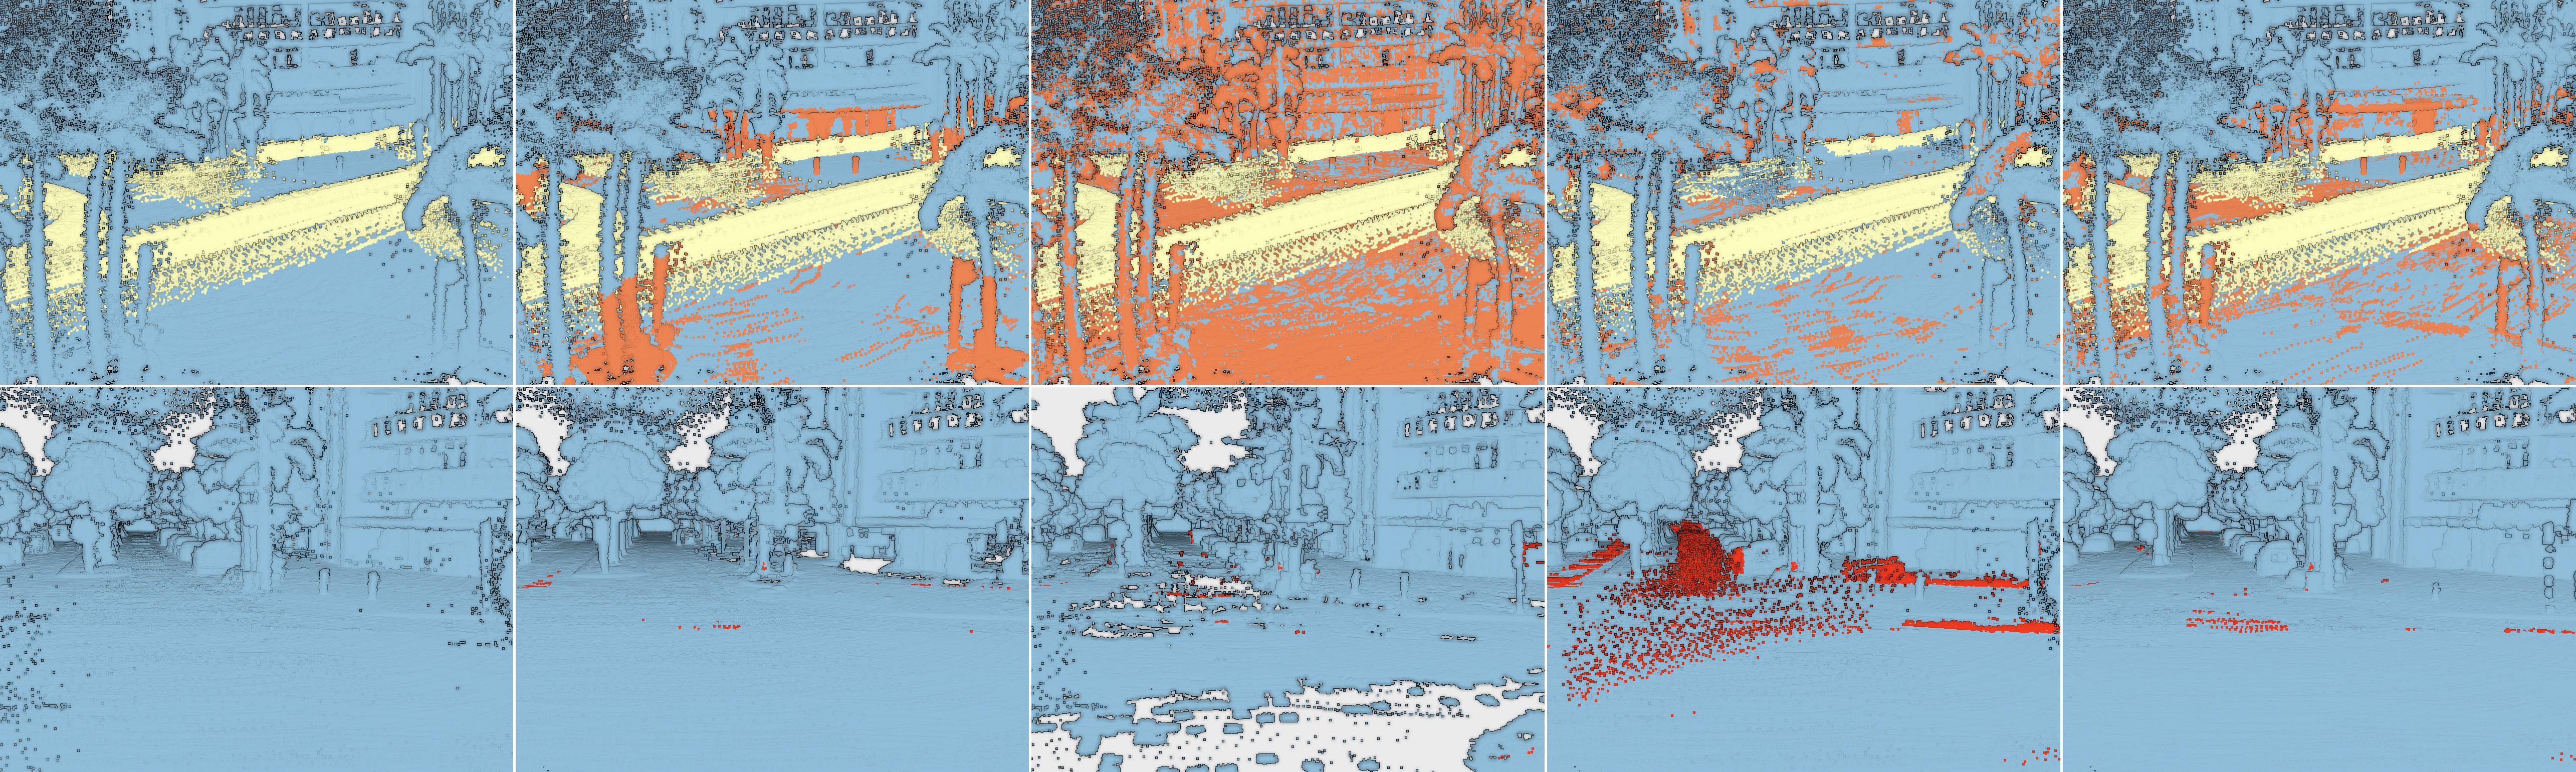

In [ ]:
from PIL import Image
from IPython.display import display
# Load the images
select_data = "av2"
algorithms = ["erasor", "octomap", "dynablox", "dufomap"]

Result_Folder = "/home/kin/workspace/DUFOMap/data"
def read_all_img(show_type="clean", data_name="05"):
    image_filenames = []
    image_filenames.append(f"{Result_Folder}/{data_name}/imgs/gt_{show_type}.png")
    for algo in algorithms:
        image_filenames.append(f"{Result_Folder}/{data_name}/imgs/{algo}_{show_type}.png")
    images = [Image.open(filename) for filename in image_filenames]
    return images

def show_combined_img(images_clean, images_dynam, data_name="05"):
    column_space = 5
    row_space = 5

    # Find the max height and total width for the new combined image
    max_height_row1 = max(img.height for img in images_clean)
    max_height_row2 = max(img.height for img in images_dynam)
    total_height = max_height_row1 + max_height_row2 + row_space
    total_width = max(
        sum(img.width for img in images_clean) + column_space * (len(images_clean) - 1),
        sum(img.width for img in images_dynam) + column_space * (len(images_dynam) - 1),
    )

    # Create a new image with the combined dimensions and a white background
    combined_image = Image.new("RGB", (total_width, total_height), color="white")


    x_offset = 0
    for img in images_dynam:
        combined_image.paste(img, (x_offset, 0))
        x_offset += img.width + column_space
    x_offset = 0
    for img in images_clean:
        combined_image.paste(img, (x_offset, max_height_row1 + row_space))
        x_offset += img.width + column_space


    # Save the combined image
    combined_image.save(f"{Result_Folder}/{data_name}/imgs/total.png")
    display(combined_image)

def show_three_combined_img(images_full, images_clean, images_dynam, data_name="05"):
    column_space = 5
    row_space = 5

    # Find the max height and total width for the new combined image
    max_height_row0 = max(img.height for img in images_full)
    max_height_row1 = max(img.height for img in images_clean)
    max_height_row2 = max(img.height for img in images_dynam)
    total_height = max_height_row0 + max_height_row1 + max_height_row2 + 2*row_space

    total_width = max(
        sum(img.width for img in images_full) + column_space * (len(images_full) - 1),
        sum(img.width for img in images_clean) + column_space * (len(images_clean) - 1),
        sum(img.width for img in images_dynam) + column_space * (len(images_dynam) - 1),
    )

    # Create a new image with the combined dimensions and a white background
    combined_image = Image.new("RGB", (total_width, total_height), color="white")

    # Paste images_full row
    x_offset = 0
    for img in images_full:
        combined_image.paste(img, (x_offset, 0))
        x_offset += img.width + column_space

    # Paste images_dynam row
    x_offset = 0
    for img in images_dynam:
        combined_image.paste(img, (x_offset, max_height_row0 + row_space))
        x_offset += img.width + column_space

    # Paste images_clean row
    x_offset = 0
    for img in images_clean:
        combined_image.paste(img, (x_offset, max_height_row0 + max_height_row1 + 2*row_space))
        x_offset += img.width + column_space

    # Save the combined image
    combined_image.save(f"{Result_Folder}/{data_name}/imgs/total.png")
    display(combined_image)


print("Showing images for data: ", select_data, f"saving {Result_Folder}/{select_data}/imgs/total.png")
# images_full = read_all_img(show_type="full", data_name=select_data)
images_clean = read_all_img(show_type="clean", data_name=select_data)
images_dynam = read_all_img(show_type="dynamic", data_name=select_data)
show_combined_img(images_clean, images_dynam, data_name=select_data)
# show_three_combined_img(images_full, images_dynam,images_clean, data_name=select_data)

In [ ]:
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
algorithms = ["removert", "erasor", "octomap", "dufomap"]
def read_all_img(show_type="clean", data_name="05"):
    image_filenames = []
    image_filenames.append(f"{Result_Folder}/{data_name}/imgs/gt_{show_type}.png")
    for algo in algorithms:
        image_filenames.append(f"{Result_Folder}/{data_name}/imgs/{algo}_{show_type}.png")
    images = [Image.open(filename) for filename in image_filenames]
    return images

def show_combined_img(images_clean, images_dynam, data_name="05"):
    column_space = 5
    row_space = 5

    # Find the max height and total width for the new combined image
    max_height_row1 = max(img.height for img in images_clean)
    caption_space = 100
    max_height_row2 = max(img.height + caption_space for img in images_dynam)
    total_height = max_height_row1 + max_height_row2 + row_space
    total_width = max(
        sum(img.width for img in images_clean) + column_space * (len(images_clean) - 1),
        sum(img.width for img in images_dynam) + column_space * (len(images_dynam) - 1),
    )

    # Create a new image with the combined dimensions and a white background
    combined_image = Image.new("RGB", (total_width, total_height), color="white")
    draw = ImageDraw.Draw(combined_image)

    x_offset = 0
    for img in images_dynam:
        combined_image.paste(img, (x_offset, 0))
        x_offset += img.width + column_space
    # Define the font and the space for the captions
    try:
        font = ImageFont.truetype("arial.ttf", 16)  # Load a custom TTF font
    except OSError:
        font = ImageFont.load_default()  # Load the default font if the custom font is unavailable
    font.size = 50
    x_offset = 0
    algorithms.insert(0, "Ground Truth")
    for id_, img in enumerate(images_clean):
        combined_image.paste(img, (x_offset, max_height_row1 + row_space))
        x_offset += img.width + column_space
        caption = algorithms[id_]
        caption_width, _ = draw.textsize(caption, font=font)
        caption_x = x_offset + (img.width - caption_width) // 2
        caption_y = max_height_row1 + row_space + img.height
        draw.text((caption_x, caption_y), caption, font=font, fill=(0, 0, 0))
        x_offset += img.width + column_space


    # Save the combined image
    combined_image.save(f"{Result_Folder}/{data_name}/imgs/total.png")
    display(combined_image)

# Load the images
select_data = "semindoor"
print("Showing images for data: ", select_data, f"saving {Result_Folder}/{data_name}/imgs/total.png")
images_clean = read_all_img(show_type="clean", data_name=select_data)
images_dynam = read_all_img(show_type="dynamic", data_name=select_data)
show_combined_img(images_clean, images_dynam, data_name=select_data)

# Print Time Cost of Each Stage

Fig. 5 (Shown in the website) in our <DUFOMap: Efficient Dynamic Awareness Mapping> Paper. Check [DUFOMap Project Page](https://kth-rpl.github.io/dufomap/).

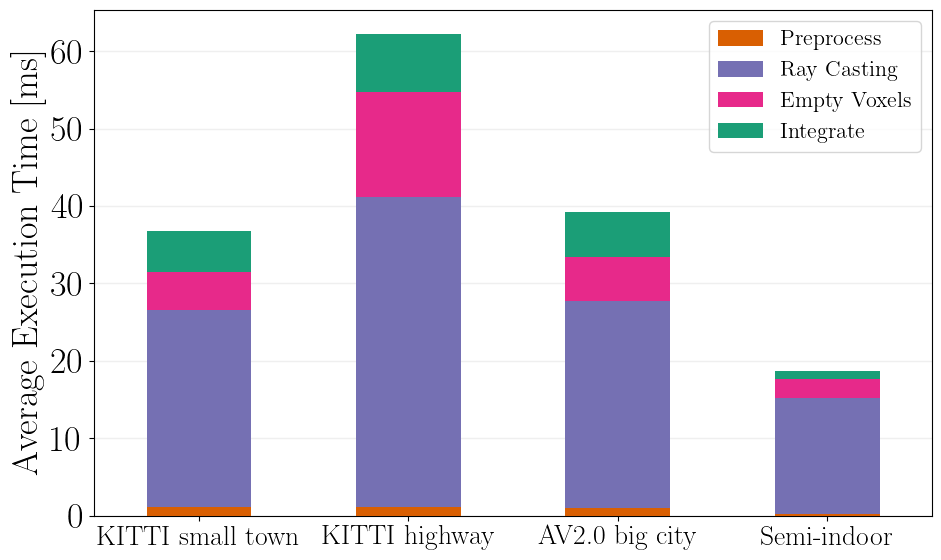

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 26
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# create DataFrame
data = {
    'KITTI small town': [0.0011, 0.0254, 0.005, 0.0053],
    'KITTI highway': [0.0011, 0.0400, 0.0136, 0.0075],
    'AV2.0 big city': [0.001, 0.0267, 0.0057, 0.0058],
    'Semi-indoor': [0.0002, 0.015, 0.0024, 0.0011],
}
colors = ['#d95f02', '#7570b3', '#e7298a', '#1b9e77', '#66a61e']
index = ['Preprocess', 'Ray Casting', 'Empty Voxels', 'Integrate']
df = pd.DataFrame(data, index=index)
df = df * 1000  # Multiply by 1000
# Create stacked bar plot
df.T.plot(kind='bar', stacked=True, figsize=(10, 6.18), color=colors, alpha=1.0, zorder=10)

plt.ylabel('Average Execution Time [ms]')
plt.grid(axis='y',alpha=0.2, linewidth=1, zorder=0)
# plt.title('Timing Histogram by Scenario')
plt.legend(loc='upper right', prop={'size': 16})
plt.xticks(rotation=0, fontsize=20)  # add this line to make x-axis labels horizontal
plt.tight_layout()
plt.savefig(f"time_on_different_cases.pdf", dpi=300)
plt.show()


# Plot Error Distribution

Fig. 5 in Our <A Dynamic Points Removal Benchmark in Point Cloud Maps> Paper, Check [arXiv link](https://arxiv.org/abs/2307.07260) to access.

In [2]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from time import time
import sys, os
BASE_DIR = os.path.abspath(os.path.join(os.path.dirname( os.path.abspath('') )))
sys.path.insert(0, BASE_DIR)
from utils.pcdpy3 import load_pcd
from utils import check_file_exists

SEQUENCE = "05"
show_algo = ["removert", "erasor", "octomap",  "octomapfg"]
Result_Folder = "/home/kin/data/Dynamic_Papers_assets/BenchmarkPaper"
all_eval_data= {}
all_eval_data[SEQUENCE] = {}

gt_pcd_path = f"{Result_Folder}/{SEQUENCE}/gt_cloud.pcd"
check_file_exists(gt_pcd_path)
gt_pc_ = load_pcd(gt_pcd_path)

for algo in show_algo:
    et_pcd_path = f"{Result_Folder}/{SEQUENCE}/eval/{algo}_output_exportGT.pcd"
    check_file_exists(et_pcd_path)
    et_pc_ = load_pcd(et_pcd_path)

    assert et_pc_.np_data.shape[0] == gt_pc_.np_data.shape[0] , \
        "Error: The number of points in et_pc_ and gt_pc_ do not match.\
        \nThey must match for evaluation, if not Please run `export_eval_pcd`."
    
    correct_dynamic = (et_pc_.np_data[:,3] == 1) * (gt_pc_.np_data[:,3] == 1)
    miss_dynamic2static = (et_pc_.np_data[:,3] == 0) * (gt_pc_.np_data[:,3] == 1)
    miss_static2dynamic = (et_pc_.np_data[:,3] == 1) * (gt_pc_.np_data[:,3] == 0)

    miss_dynamic2static_points = gt_pc_.np_data[np.where(miss_dynamic2static)[0], :3]
    correct_dynamic_points = gt_pc_.np_data[np.where(correct_dynamic)[0], :3]
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(correct_dynamic_points)
    distances, _ = nbrs.kneighbors(miss_dynamic2static_points)
    
    min_distances = distances[:, 0]

    miss_static2dynamic_points = gt_pc_.np_data[np.where(miss_static2dynamic)[0], :3]
    nbrs_static = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(correct_dynamic_points)
    distances_static, _ = nbrs_static.kneighbors(miss_static2dynamic_points)
    
    min_distances_miss_static = distances_static[:, 0]
    # Store evaluation data for each algorithm
    all_eval_data[SEQUENCE][algo] = {
        'miss_dynamic_min_distances': min_distances,
        'miss_static_min_distances': min_distances_miss_static,
    }

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1426: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


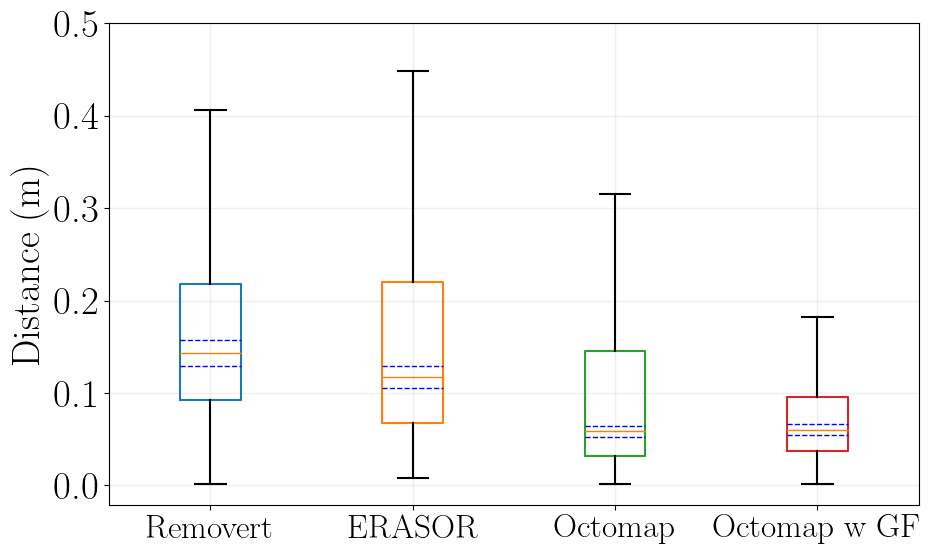

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_distribution(all_eval_data, sequence, algo_list, percent_range=10, data_label='miss_dynamic_min_distances'):
    plt.figure(figsize=(10, 6.18))

    # Set font to Times New Roman
    mpl.rcParams['font.family'] = 'Times New Roman'
    mpl.rcParams['font.size'] = 28
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    data = []
    labels = []

    for algo in algo_list:
        algo_data = all_eval_data[sequence][algo]
        min_distances = algo_data[data_label]
        name = algo.capitalize()
        if name == 'Dufomap':
            name = 'DUFOMap'
        elif name == 'Octomapfg':
            name = 'Octomap w GF'
        elif name == 'Erasor':
            name = 'ERASOR'
        data.append(min_distances)
        labels.append(name)
    box_widths = 0.3
    positions = range(1, len(algo_list) + 1)
    bp = plt.boxplot(data, positions=positions, widths=box_widths, showfliers=False)


    for i, median in enumerate(bp['medians']):
        median_x = median.get_xdata()[0]+box_widths/2
        median_y = median.get_ydata()[0]
        min_distances = data[i]
        lower_bound = median_y * (1 - percent_range / 100)
        upper_bound = median_y * (1 + percent_range / 100)
        
        # Draw horizontal lines representing the range with an offset from the median line
        line_x = [median_x - box_widths/2, median_x + box_widths/2]
        plt.plot(line_x, [lower_bound, lower_bound], 'b--', linewidth=1)
        plt.plot(line_x, [upper_bound, upper_bound], 'b--', linewidth=1)
        
        
        
    for i, box in enumerate(bp['boxes']):
        box.set_color('C{}'.format(i))
        box.set_linewidth(1.5)  # Set the line width of the box plots
    
    # Set line width for whiskers and caps
    for whisker in bp['whiskers']:
        whisker.set_linewidth(1.5)
    for cap in bp['caps']:
        cap.set_linewidth(1.5)
        
    tick_positions = np.arange(0, 0.51, 0.1)
    tick_positions = np.round(tick_positions, decimals=1)
    tick_labels = [str(position) for position in tick_positions]

    # Apply the tick positions and labels to the y-axis
    plt.yticks(tick_positions, tick_labels)
    plt.grid(alpha=0.2, linewidth=1)
    plt.xticks(positions, labels, fontsize=24)
    plt.ylabel('Distance (m)')
    plt.tight_layout()
    plt.savefig(f"{data_label}.pdf", dpi=300)
    plt.show()
show_algo = ["removert", "erasor", "octomap",  "octomapfg"]
plot_distribution(all_eval_data, '05', show_algo, data_label='miss_dynamic_min_distances')
